**Imports**

In [ ]:
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pathlib import Path
import numpy as np
import pandas
import seaborn as sns
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as tv_models
from torch.utils.data import Dataset, DataLoader
from PIL import Image

**Mounting to drive for dataset loading**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Plotting image to test if data is extracting properly**

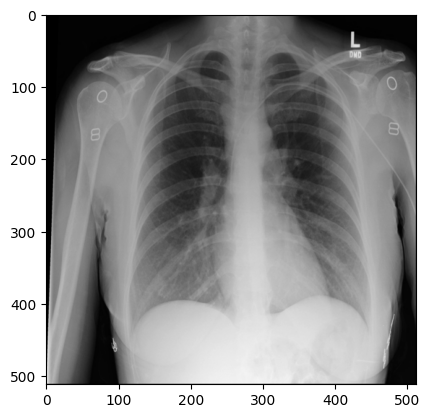

In [ ]:
SOURCE_PATH_DB = Path('/content/drive/MyDrive/ECE5400_FinalProject/TB_Chest_Radiography_Database')
SOURCE_PATH_NORM = SOURCE_PATH_DB / 'Normal'
SOURCE_PATH_TB = SOURCE_PATH_DB / 'Tuberculosis'

testing_img = Image.open(SOURCE_PATH_NORM/'Normal-42.png')
imgplot = plt.imshow(testing_img)

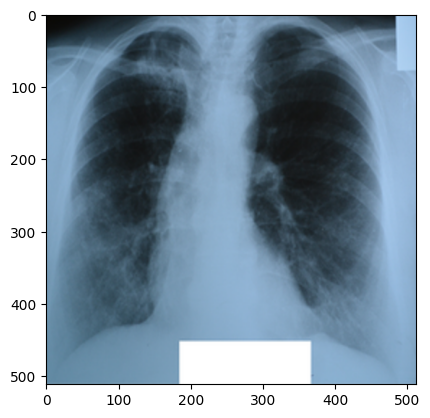

In [ ]:
testing_img_tb = Image.open(SOURCE_PATH_TB/'Tuberculosis-1.png')
plt.imshow(testing_img_tb)

In [ ]:
#Testing Image function
for img in SOURCE_PATH_NORM.glob('*.png'):
  pass

pic = Image.open(img)
print(pic)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(pic)

print(input_tensor.shape)

<PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512 at 0x7F8C3C5CE950>
torch.Size([3, 224, 224])


**Check how many images are present for both normal and tuberculosis cases**

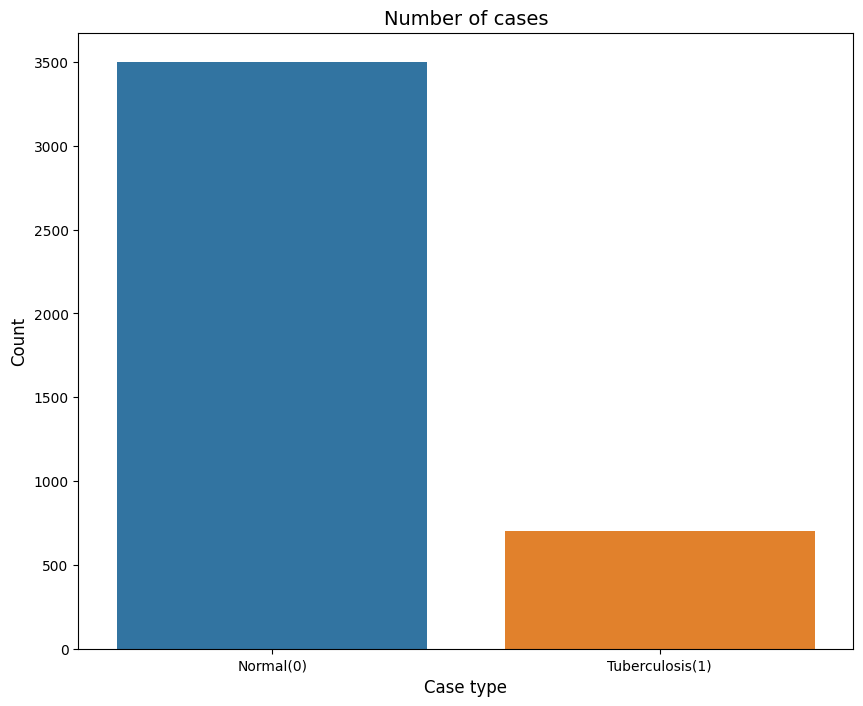

In [ ]:
all_data = []

# Add all the normal lung xrays to the data list
for img in SOURCE_PATH_NORM.glob('*.png'):
  all_data.append((img, 0))

# Add all tuberculosis lung xrays to the data list
for img in SOURCE_PATH_TB.glob('*.png'):
  all_data.append((img,1))

# Turn list of data into dataframe
all_data = pandas.DataFrame(all_data, columns=['image', 'label'],index=None)

# Shuffle the data
all_data = all_data.sample(frac=1.).reset_index(drop=True)

# Count of normal and tuberculosis cases
cases_count = all_data['label'].value_counts()

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Tuberculosis(1)'])
plt.show()


**Extract the images from the folder**

In [ ]:
# Normal cases data
count = 0
for img in SOURCE_PATH_NORM.glob('*.png'):
  count += 1

norm_data = np.array([None]*count)

for i, img in enumerate(SOURCE_PATH_NORM.glob('*.png')):
  norm_data[i] = Image.open(img)
  if norm_data[i].mode != "L":
    norm_data[i] = norm_data[i].convert("L")

# Tuberculosis cases data
count = 0
for img in SOURCE_PATH_TB.glob('*.png'):
  count += 1

tb_data = np.array([None]*count)

for i, img in enumerate(SOURCE_PATH_TB.glob('*.png')):
  tb_data[i] = Image.open(img)
  if tb_data[i].mode != "L":
    tb_data[i] = tb_data[i].convert("L")


# Reduce Normal cases data to mitigate overloading
np.random.shuffle(norm_data)
norm_data = norm_data[0:len(tb_data)]

# # Create labels arrays and combine all data
norm_labels = np.array([0]*len(norm_data))
tb_labels = np.array([1]*len(tb_data))

all_labels = np.concatenate((norm_labels, tb_labels))
all_data = np.concatenate((norm_data, tb_data))

**Split the data, preprocess and add to data loader**

In [ ]:
# Split training and testing data
input_train, input_test, labels_train, labels_test = train_test_split(all_data, all_labels, test_size=0.20, random_state=42)

# Define relevant variables for the ML task
batch_size = 4
num_classes = 2
learning_rate = 0.001
num_epochs = 50

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use transforms.compose method to reformat images for modeling,
# and save to variable all_transforms for later use
all_transforms = transforms.Compose([transforms.Resize((28,28)),
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5, ), (0.5, ))
                                     ])

for i, data in enumerate(input_train):
  input_train[i] = all_transforms(data)

for i, data in enumerate(input_test):
  input_test[i] = all_transforms(data)

# Put inputs and labels into tuples
train_dataset = [0]*len(input_train)
test_dataset = [0]*len(input_test)

labels_train = torch.from_numpy(labels_train)
labels_test = torch.from_numpy(labels_test)

for i, input_set in enumerate(zip(input_train, labels_train)):
  train_dataset[i] = input_set

for i, input_set in enumerate(zip(input_test, labels_test)):
  test_dataset[i] = input_set

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

**Convolution Neural Network**

In [ ]:
# Creating a CNN class
class ConvNeuralNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(in_features=1024, out_features=8)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=8, out_features=num_classes)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        out = self.conv_layer4(out)
        out = self.max_pool2(out)

        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out



**Instantiating model and optimizer**

In [ ]:
model = ConvNeuralNet(num_classes)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.9)  

total_step = len(train_loader)

**Training**

In [ ]:
loss_values = []

# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    running_loss = 0.0
	  #Load in the data in batches using the train_loader object
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels.squeeze())
        running_loss =+ loss.item() * images.size(0)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_values.append(running_loss/len(train_dataset))

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 0.5474
Epoch [2/50], Loss: 0.0752
Epoch [3/50], Loss: 0.4271
Epoch [4/50], Loss: 0.4191
Epoch [5/50], Loss: 0.2239
Epoch [6/50], Loss: 0.0517
Epoch [7/50], Loss: 0.0081
Epoch [8/50], Loss: 0.0807
Epoch [9/50], Loss: 0.0105
Epoch [10/50], Loss: 0.0041
Epoch [11/50], Loss: 0.8929
Epoch [12/50], Loss: 0.0089
Epoch [13/50], Loss: 0.0173
Epoch [14/50], Loss: 0.1760
Epoch [15/50], Loss: 0.5382
Epoch [16/50], Loss: 0.0010
Epoch [17/50], Loss: 0.0046
Epoch [18/50], Loss: 0.0235
Epoch [19/50], Loss: 0.7098
Epoch [20/50], Loss: 0.0020
Epoch [21/50], Loss: 0.0065
Epoch [22/50], Loss: 0.1572
Epoch [23/50], Loss: 0.0266
Epoch [24/50], Loss: 0.0021
Epoch [25/50], Loss: 0.0686
Epoch [26/50], Loss: 0.4704
Epoch [27/50], Loss: 0.0000
Epoch [28/50], Loss: 0.0001
Epoch [29/50], Loss: 0.0418
Epoch [30/50], Loss: 0.0079
Epoch [31/50], Loss: 0.0002
Epoch [32/50], Loss: 0.0206
Epoch [33/50], Loss: 0.0028
Epoch [34/50], Loss: 0.1715
Epoch [35/50], Loss: 0.0032
Epoch [36/50], Loss: 0.0001
E

**Plot of model loss over each epoch**

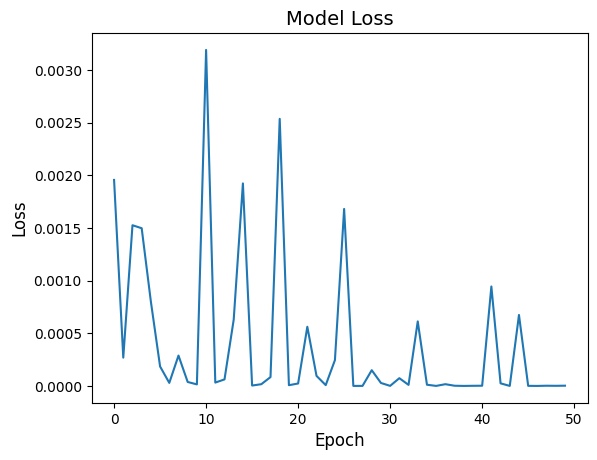

In [ ]:
plt.plot(loss_values)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.show()

**Testing the model**

Accuracy of the network on the 280 test images: 94.64285714285714 %
tn: 132, fp: 8, fn: 7, tp: 133

*************** CLASSIFICATION REPORT ***************
              precision    recall  f1-score   support

           0       0.95      0.94      0.95       140
           1       0.94      0.95      0.95       140

    accuracy                           0.95       280
   macro avg       0.95      0.95      0.95       280
weighted avg       0.95      0.95      0.95       280



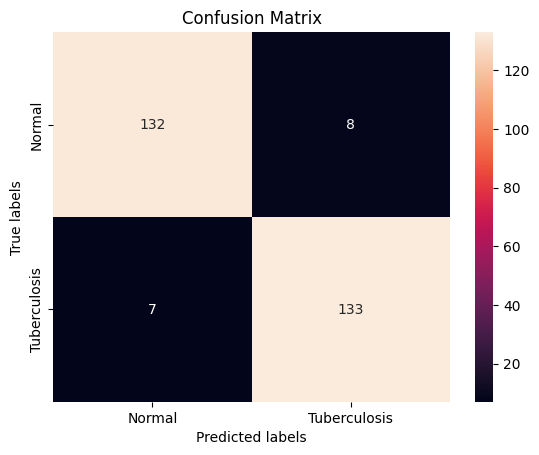

In [ ]:
from sklearn.metrics import confusion_matrix
labels_list = []
predicted_list = []

# Test function to check model accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        labels_list.append(labels.cpu().numpy())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.append(predicted.cpu().numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

# Turn tensor to numpy array and flatten 
predicted_list = np.array(predicted_list)
predicted_list = predicted_list.flatten()
labels_list = np.array(labels_list)
labels_list = labels_list.flatten()

confusion_matrix_df = pandas.DataFrame(confusion_matrix(labels_list, predicted_list))

ax= plt.subplot()
sns.heatmap(confusion_matrix_df, annot=True, ax=ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Normal', 'Tuberculosis']); ax.yaxis.set_ticklabels(['Normal', 'Tuberculosis']);

tn, fp, fn, tp = confusion_matrix(labels_list, predicted_list).ravel()
print('tn: {}, fp: {}, fn: {}, tp: {}'.format(tn, fp, fn, tp))

print()
print('*************** CLASSIFICATION REPORT ***************')
print(classification_report(labels_list, predicted_list))